In [1]:
from scipy.stats.distributions import poisson
from pprint import pprint
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import time 
from math import sqrt
%matplotlib inline

## Modeling Project
- Jingxuan SUN (js3422)
- 2019.12.3
- Notes: 
    - During the simulation process, I tried 2 different sets of policies and 3 different reward functions, in order to find a meaningful type of policies to do the optimization. 
    - The first type of policies is completely the same as the inventory problem introduced in the lecture (eg. replenishing to 10 screenings when there are fewer than 2 screenings "left"), it didn't really need any optimization, because intuitively the more I show the more profit I get, as it doesn't make sense that a film would have incurred some cost just because it stays more days at the cinema. Therefore, I did the optimization on the second set of policies, which is described in details in the report. 
    - The adjustment made in the reward functions basically aims to make the profit values as close to the real life cinema profit as possible. 
    - All the trials are included in this notebook, so there might be considerable amount of code. The final policy and reward function described in details in the report corresponds to the following functions: get_optimal_policy2, transition2, get_rewards, and R_. 

### Parameters

In [2]:
SHOWS = 10
CAPACITY = 20
TIME = 1000

ticket = 50 # ticket, snacks...
fix_cost_per_show = 100 # corresponding to storage cost on left inventory
op_cost_per_day = 500

BETA = 0.98

### Simulate single policy

In [4]:
def transition1(thresh, mu):
    P = [[0 for _ in range(SHOWS+1)] for _ in range(SHOWS+1)]
    for i in range(thresh+1):
        P[i][SHOWS] = 1 - poisson.cdf(CAPACITY*(SHOWS-1), mu)
        P[i][0] = poisson.pmf(0, mu)
        for j in range(1, SHOWS):
            P[i][j] = poisson.cdf((SHOWS-j)*CAPACITY, mu)\
            - poisson.cdf((SHOWS-j-1)*CAPACITY, mu)
    for i in range(thresh+1, SHOWS+1):
        P[i][i] = poisson.pmf(0, mu)
        P[i][0] = 1 - poisson.cdf((i-1)*CAPACITY, mu)
        for j in range(1, i):
            P[i][j] = poisson.cdf((i-j)*CAPACITY, mu)\
            - poisson.cdf((i-j-1)*CAPACITY, mu)
    for row in P:
        assert sum(row) == 1
    return P

In [5]:
# policy: refill to 10 shows if sold 8 or more
thresh = 2
mu = 100
P = transition1(thresh, mu)

In [7]:
def simulate(P, X0, time=TIME):
    X = X0 # states are 0-10
    Xs = []
    for _ in range(time):
        p_gen = np.random.random()
        p_cum = 0
        Xs.append(X)
        for i, p in enumerate(P[X]):
            p_cum += p 
            if p_gen <= p_cum:
                X_new = i
                break
        X = X_new
    return Xs

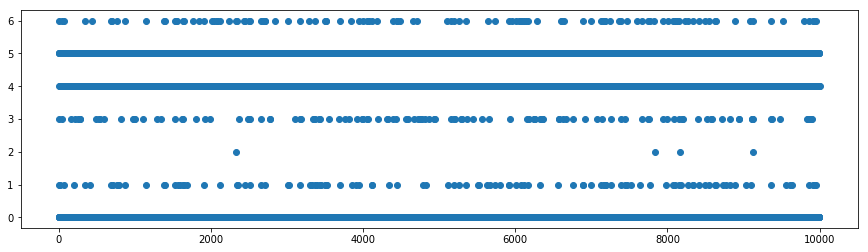

In [9]:
Xs = simulate(P, 5, 10000) # as mu = 100, start with X0 = 5
plt.figure(figsize=(15,4))
plt.scatter([n for n in range(10000)], Xs)

In [7]:
# stationary distribution of number of shows left
def get_pi(Xs):
    pi = Counter(Xs)
    for i in range(shows+1):
        if i not in pi:
            pi[i] = 0
    pi = [(k, v/time) for k, v in pi.items()]
    pi = sorted(pi, key=lambda x: x[0])
    pprint(pi)
    pi = [x[1] for x in pi]
    return pi

pi = get_pi(Xs)

[(0, 0.4852),
 (1, 0.0143),
 (2, 0.0005),
 (3, 0.0103),
 (4, 0.2248),
 (5, 0.2524),
 (6, 0.0125),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0),
 (10, 0.0)]


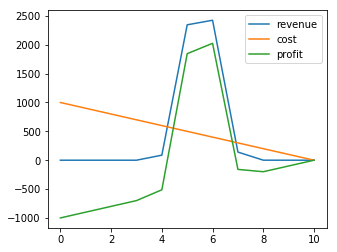

In [31]:
# profit per day
R1 = lambda i: \
sum([ticket * d * poisson.pmf(d, mu) \
     for d in range(max(0, CAPACITY * (i-1) + 1), CAPACITY * i + 1)]) \
    - fix_cost_per_show * (10 - i) - op_cost_per_day

revenue, cost, profit = [], [], []
for i in range(SHOWS+1):
    r = sum([ticket * d * poisson.pmf(d, mu) \
             for d in range(max(0, CAPACITY * (i-1) + 1), CAPACITY * i + 1)])
    c = fix_cost_per_show * (10 - i)
    revenue.append(r)
    cost.append(c)
    profit.append(r - c)
    
plt.figure(figsize=(5,4))
plt.plot([n for n in range(11)], revenue, label='revenue')
plt.plot([n for n in range(11)], cost, label='cost')
plt.plot([n for n in range(11)], profit, label='profit')
plt.legend()

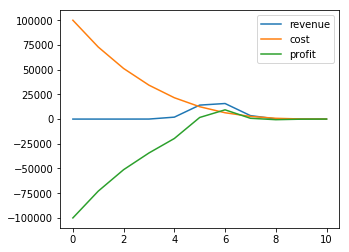

In [33]:
R2 = lambda i: \
sum([ticket * d * sqrt(poisson.pmf(d, mu)) \
     for d in range(max(0, CAPACITY * (i-1) + 1), CAPACITY * i + 1)]) \
    - fix_cost_per_show * (10 - i) ** 3 - op_cost_per_day

revenue, cost, profit = [], [], []
for i in range(SHOWS+1):
    r = sum([ticket * d * sqrt(poisson.pmf(d, mu)) \
             for d in range(max(0, CAPACITY * (i-1) + 1), CAPACITY * i + 1)])
    c = fix_cost_per_show * (10 - i) ** 3
    revenue.append(r)
    cost.append(c)
    profit.append(r - c)
    
plt.figure(figsize=(5,4))
plt.plot([n for n in range(11)], revenue, label='revenue')
plt.plot([n for n in range(11)], cost, label='cost')
plt.plot([n for n in range(11)], profit, label='profit')
plt.legend()

In [34]:
max_r = 0
screens = 0
for i, R in enumerate([R1, R2]):
    print('\n========== R{} =========='.format(i+1))
    for i in range(11):
        r = R(i)
        print('avg daily profit of showing {} screens={}'.format(i, r))
        if r > max_r:
            screens = i
            max_r = r
    print('max daily profit is when showing {} screens, r={}'.format(screens, max_r))


========== R1 ==========
avg daily profit of showing 0 screens=-1500.0
avg daily profit of showing 1 screens=-1400.0
avg daily profit of showing 2 screens=-1299.9999999851989
avg daily profit of showing 3 screens=-1199.9682924976646
avg daily profit of showing 4 screens=-1012.7750949357562
avg daily profit of showing 5 screens=1346.2493960229958
avg daily profit of showing 6 screens=1525.3420215715932
avg daily profit of showing 7 screens=-659.3062627469865
avg daily profit of showing 8 screens=-699.5418699635516
avg daily profit of showing 9 screens=-599.9998974671753
avg daily profit of showing 10 screens=-499.99999999794755
max daily profit is when showing 6 screens, r=1525.3420215715932

========== R2 ==========
avg daily profit of showing 0 screens=-100500.0
avg daily profit of showing 1 screens=-73399.99999997881
avg daily profit of showing 2 screens=-51699.9892017055
avg daily profit of showing 3 screens=-34775.26499060082
avg daily profit of showing 4 screens=-20145.1141127271

In [17]:
# E(discounted reward) for each X0
def get_rewards(P, R_func):
    E_avgs = []
    E_discounts = []
    start = time.time()
    for i in range(11): 
#         print('simulate for start state X0={}'.format(i))
#         start = time.time()
        X0 = i 
        avgs = []
        discounts = []
        for s in range(10): # simulate 1000 realizations
            Xs = simulate(P, X0, TIME) # show the movie for 1000 days for example
            avg = sum(Xs)/TIME
            discount = sum([(BETA ** k) * R_func(10 - Xk) \
                            for k, Xk in enumerate(Xs)]) # Xk = shows left
            avgs.append(avg)
            discounts.append(discount)
        E_avg = sum(avgs)/len(avgs)
        E_discount = sum(discounts)/len(discounts)
        E_avgs.append(E_avg)
        E_discounts.append(E_discount)
    print('took time {}'.format(time.time() - start))

    pprint(E_avgs)
    pprint(E_discounts)
    return E_discounts

In [18]:
R = get_rewards(P, R1)
print('best show {} screenings, max reward={}, average reward={}'\
      .format(10 - R.index(max(R)), max(R), sum(R)/len(R)))

took time 14.475147008895874
[2.277, 2.261, 2.268, 2.274, 2.262, 2.299, 2.268, 2.264, 2.271, 2.284, 2.261]
[320828.48024507466,
 331184.85922259366,
 327716.19826025126,
 311675.8555244135,
 320903.23434839473,
 333695.23094426404,
 319593.2292241026,
 321784.9545405868,
 321253.9602009855,
 300564.4274782766,
 322454.4065675982]
best show 5 screenings, max reward=333695.23094426404, average reward=321059.5305960492


### Find optimal policy

In [22]:
def get_optimal_policy1(mu, R_func):
    screens = []
    max_r = []
    avg_r = []
    for thresh in range(SHOWS+1):
        print('\n========== start simulation with thresh={} =========='.format(thresh))
        print('transition matrix:')
        P = transition1(thresh, mu)
        print('infinite horizon discount rewards:')
        R = get_rewards(P, R_func)
        screen_first_day = 10 - R.index(max(R))
        max_reward = max(R)
        avg_reward = sum(R)/len(R)
        print('best show {} screenings, max reward={}, average reward={}'\
              .format(screen_first_day, max_reward, avg_reward))
        screens.append(screen_first_day)
        max_r.append(max_reward)
        avg_r.append(avg_reward)
    return screens, max_r, avg_r

In [40]:
def plot_r(max_r, avg_r):
    plt.figure(figsize=(5,4))
    plt.plot([n for n in range(len(max_r))], max_r, label='max')
    plt.plot([n for n in range(len(max_r))], avg_r, label='avg')
    plt.legend()


========== start simulation with thresh=0 ==========
transition matrix:
infinite horizon discount rewards:
took time 15.442644834518433
[2.234, 2.264, 2.249, 2.248, 2.247, 2.25, 2.24, 2.272, 2.264, 2.253, 2.247]
[321308.64701085986,
 304716.21906061925,
 311149.32693518,
 292493.00068709534,
 320218.7972788637,
 321705.0321001929,
 318949.2377075076,
 315318.26558378426,
 300243.5617313326,
 287464.7234534963,
 328721.24504642404]
best show 0 screenings, max reward=328721.24504642404, average reward=311117.09605412325

========== start simulation with thresh=1 ==========
transition matrix:
infinite horizon discount rewards:
took time 15.39163589477539
[2.276, 2.269, 2.303, 2.301, 2.276, 2.292, 2.269, 2.288, 2.273, 2.288, 2.294]
[328637.534179512,
 316456.61580836255,
 313596.4044294679,
 313079.3660942648,
 341915.8592281651,
 321083.9921827317,
 299574.3492082082,
 316559.24271589273,
 295417.55818498344,
 324006.23797296674,
 303936.68666291307]
best show 6 screenings, max reward=34

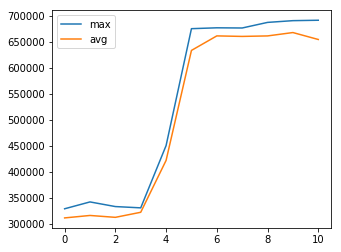

In [28]:
screens, max_r, avg_r = get_optimal_policy1(100, R1)
plot_r(max_r, avg_r)


========== start simulation with thresh=0 ==========
transition matrix:
infinite horizon discount rewards:
took time 16.032744884490967
[2.26, 2.253, 2.261, 2.264, 2.239, 2.23, 2.246, 2.261, 2.264, 2.247, 2.265]
[89368.19762949547,
 110889.47957480852,
 58593.65944886733,
 92106.03389148462,
 60248.90331307007,
 89614.56649954134,
 47655.32065256996,
 53478.318524401344,
 41561.83822727623,
 21233.85855444988,
 -16495.021625611273]
best show 9 screenings, max reward=110889.47957480852, average reward=58932.28679003213

========== start simulation with thresh=1 ==========
transition matrix:
infinite horizon discount rewards:
took time 15.439977884292603
[2.259, 2.245, 2.294, 2.275, 2.291, 2.272, 2.281, 2.306, 2.288, 2.291, 2.279]
[63014.93559543267,
 90691.70181760873,
 76956.66675750162,
 56024.56101996082,
 85791.77451700409,
 71374.62750492412,
 64119.89895036869,
 21572.753603353707,
 32401.3624702029,
 8713.195561684986,
 -14277.95568347119]
best show 9 screenings, max reward=9069

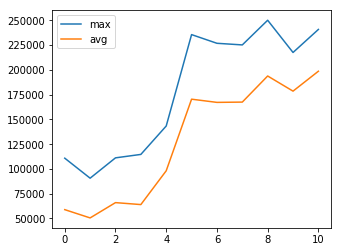

In [36]:
screens, max_r, avg_r = get_optimal_policy1(100, R2)
plot_r(max_r, avg_r)

### 🤬 Change a policy

In [37]:
def transition2(thresh, mu):
    P = [[0 for _ in range(SHOWS+1)] for _ in range(SHOWS+1)]
    for i in range(SHOWS+1):
        if thresh <= i: 
            P[i][i-thresh] = poisson.cdf(CAPACITY * (i - 1), mu)
        else:
            P[i][0] = poisson.cdf(CAPACITY * (i - 1), mu)
        if i + thresh <= SHOWS:
            P[i][i+thresh] = 1 - poisson.cdf(CAPACITY * i, mu)
        else:
            P[i][10] = 1 - poisson.cdf(CAPACITY * i, mu)
        P[i][i] += poisson.cdf(CAPACITY * i, mu) - poisson.cdf(CAPACITY * (i - 1), mu)
    for i, row in enumerate(P):
        try:
            assert sum(row) == 1
        except:
            print(i, row)
    return P

In [38]:
# thresh should start from 1
pprint(transition2(5, 100))

[[3.7200759760208177e-44, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0],
 [3.7200759760208177e-44, 1.905558742030033e-22, 0, 0, 0, 0, 1.0, 0, 0, 0, 0],
 [1.905558742030033e-22,
  0,
  7.519646690716326e-12,
  0,
  0,
  0,
  0,
  0.9999999999924803,
  0,
  0,
  0],
 [7.519646690906881e-12,
  0,
  0,
  1.0812210650597315e-05,
  0,
  0,
  0,
  0,
  0.9999891877818298,
  0,
  0],
 [1.0812218170244006e-05,
  0,
  0,
  0,
  0.022638364424085393,
  0,
  0,
  0,
  0,
  0.9773508233577444,
  0],
 [0.022649176642255638,
  0,
  0,
  0,
  0,
  0.5039130218877429,
  0,
  0,
  0,
  0,
  0.4734378014700015],
 [0,
  0.5265621985299985,
  0,
  0,
  0,
  0,
  0.45076847239164874,
  0,
  0,
  0,
  0.02266932907835273],
 [0,
  0,
  0.9773306709216473,
  0,
  0,
  0,
  0,
  0.022605316441137835,
  0,
  0,
  6.401263721489414e-05],
 [0,
  0,
  0,
  0.9999359873627851,
  0,
  0,
  0,
  0,
  6.400002057682652e-05,
  0,
  1.261663806761959e-08],
 [0,
  0,
  0,
  0,
  0.9999999873833619,
  0,
  0,
  0,
  0,
  1.2616412803367

In [22]:
def get_optimal_policy2(mu, R_func):
    screens = []
    max_r = []
    avg_r = []
    for thresh in range(1, 10):
        print('\n========== start simulation with thresh={} =========='.format(thresh))
        print('transition matrix:')
        P = transition2(thresh, mu)
        print('infinite horizon discount rewards:')
        R = get_rewards(P, R_func)
        screen_first_day = 10 - R.index(max(R))
        max_reward = max(R)
        avg_reward = sum(R)/len(R)
        print('best show {} screenings for the 1st day, reward={}'\
              .format(screen_first_day, max_reward))
        print('average reward={}'.format(avg_reward))
        screens.append(screen_first_day)
        max_r.append(max_reward)
        avg_r.append(avg_reward)
    return screens, max_r, avg_r


========== start simulation with thresh=1 ==========
transition matrix:
infinite horizon discount rewards:
took time 15.55594515800476
[5.455, 5.481, 5.445, 5.494, 5.503, 5.45, 5.471, 5.476, 5.47, 5.523, 5.47]
[336085.4487897669,
 364664.88962001516,
 382159.8537347291,
 367492.21127370506,
 309664.94488211605,
 356582.07198790624,
 364944.8333497033,
 358877.0264523791,
 380548.9814630492,
 307464.8208235526,
 339222.09444426344]
best show 8 screenings for the 1st day, reward=382159.8537347291
average reward=351609.74334738054

========== start simulation with thresh=2 ==========
transition matrix:
infinite horizon discount rewards:
took time 14.946410179138184
[5.328, 5.612, 5.358, 5.608, 5.306, 5.628, 5.346, 5.636, 5.346, 5.646, 5.366]
[287317.8008769625,
 424596.9194452193,
 311411.2318144953,
 417076.50136004214,
 289388.8202599925,
 398214.87041667436,
 272794.5261084005,
 374507.39774829627,
 230475.7637661038,
 389903.05532633374,
 261853.1727656079]
best show 9 screenings for

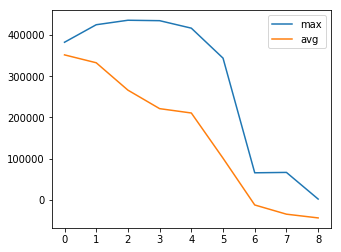

In [59]:
R_ = lambda i: \
sum([ticket * d * sqrt(poisson.pmf(d, mu)) \
     for d in range(max(0, CAPACITY * (i-1) + 1), CAPACITY * i + 1)]) \
     - fix_cost_per_show * (10 - i) - op_cost_per_day

screens, max_r, avg_r = get_optimal_policy2(100, R_)
plot_r(max_r, avg_r)

### DP

In [6]:
p_dp = [0 for _ in range(SHOWS+1)]
for i in range(1, SHOWS+1):
    p_dp[i] = poisson.cdf(CAPACITY*i, mu) - poisson.cdf(CAPACITY*(i-1), mu)
p_dp[10] = 1 - poisson.cdf(CAPACITY * SHOWS, mu)
print('probabilities for changing state:', p_dp)

probabilities for changing state: [0, 1.905558742030033e-22, 7.519646690716326e-12, 1.0812210650597315e-05, 0.022638364424085393, 0.5039130218877429, 0.45076847239164874, 0.022605316441137835, 6.400002057682652e-05, 1.2616412803367894e-08, 0.0]


In [21]:
B = 10 # budget = num shows
V = [0 for _ in range(B+1)]
iters = []
cont = True
V_prev = V[:]

R_ = lambda i: \
sum([ticket * d * sqrt(poisson.pmf(d, mu)) \
     for d in range(max(0, CAPACITY * (i-1) + 1), CAPACITY * i + 1)]) \
     - fix_cost_per_show * (10 - i) - op_cost_per_day

while cont:
    for x in range(1, B+1): # V(x)
        tmp = R_(10-x)
        for k in range(1-x, 10-x+1):
            # left (x+k), sell 10-(x+k), according p index 11-(x+k)
            tmp += BETA * p_dp[11-(x+k)] * V[x+k]   
        V[x] = tmp     
    if abs(V[-1] - V_prev[-1]) < 1:
        cont = False
    else:
        V_prev = V[:]
        iters.append(V[-1])
        print(V[-1])

8490.795978289461
17375.588671348516
25827.011875817618
34003.14786160399
41945.680772087224
49668.99027973221
57180.93486593174
64487.72264299002
71595.05586505443
78508.40233364052
85233.06215078603
91774.18643677185
98136.78470936416
104325.72952479588
110345.7603977076
116201.48747484322
121897.39507585205
127437.84512980797
132827.08051614478
138069.22831398877
143168.3029627088
148128.2093361835
152952.74573315712
157645.60678597933
162210.38628995614
166650.5799554804
170969.5880850485
175170.71817721383
179257.18745947044
183232.12535200777
187098.5758642221
190859.49992582042
194517.77765430184
198076.21056055286
201537.52369424628
204904.36773068484
208179.32100069025
211364.89146509007
214463.5186353152
217477.57544157907
220409.37005006865
223261.1476305395
226035.0920756675
228733.32767347535
231357.92073411297
233910.88117223917
236394.16404621516
238809.67105528904
241159.2519959184
243444.70617834496
245667.7838045076
247830.18730834755
249933.57265953327
251979.5506316

### Add some seasonality

In [42]:
def simulate_seasonal(Ps, periods, X0, time=TIME):
    X = X0 # states are 0-10
    curr_period = 0
    period_type = 0
    P = Ps[period_type]
    Xs = []
    for _ in range(time):
        p_gen = np.random.random()
        p_cum = 0
        Xs.append(X)
        for i, p in enumerate(P[X]):
            p_cum += p 
            if p_gen <= p_cum:
                X_new = i
                break
        X = X_new
        curr_period += 1
        if curr_period == periods[period_type]:
            curr_period = 0
            period_type = (period_type + 1) % len(Ps)
            P = Ps[period_type]
            
    return Xs

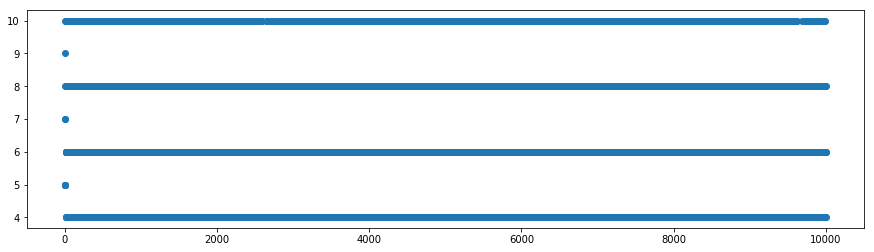

In [44]:
p1 = transition2(2, 100)
p2 = transition2(2, 200)
Xs = simulate_seasonal([p1, p2], [5, 2], 5, 10000)
plt.figure(figsize=(15,4))
plt.scatter([n for n in range(10000)], Xs)

In [76]:
def get_seasonal_rewards(Ps, periods, R_func):
    E_avgs = []
    E_discounts = []
    start = time.time()
    for i in range(SHOWS+1): 
        X0 = i 
        avgs = []
        discounts = []
        for s in range(10): # simulate 10000 realizations
            Xs = simulate_seasonal(Ps, periods, X0, TIME) # show the movie for 1000 days for example
            avg = sum(Xs)/TIME
            discount = sum([(BETA ** k) * R_func(10 - Xk) \
                            for k, Xk in enumerate(Xs)]) # Xk = shows left
            avgs.append(avg)
            discounts.append(discount)
        E_avg = sum(avgs)/len(avgs)
        E_discount = sum(discounts)/len(discounts)
        E_avgs.append(E_avg)
        E_discounts.append(E_discount)
#     print('took time {}'.format(time.time() - start))

#     pprint(E_avgs)
#     pprint(E_discounts)
    return E_discounts

In [56]:
get_seasonal_rewards([p1, p2], [5, 2], R_)

took time 12.882125854492188
[6.564, 6.452, 6.504, 6.508, 6.538, 6.456, 6.482, 6.517, 6.378, 6.448, 6.458]
[132846.70898308238,
 160178.03259254483,
 144240.21702946056,
 148206.2045579331,
 147638.84028125866,
 204418.45750529904,
 79119.77351295702,
 170106.47512660007,
 155056.77891958528,
 166227.63463143024,
 126511.40812162153]


[132846.70898308238,
 160178.03259254483,
 144240.21702946056,
 148206.2045579331,
 147638.84028125866,
 204418.45750529904,
 79119.77351295702,
 170106.47512660007,
 155056.77891958528,
 166227.63463143024,
 126511.40812162153]

In [73]:
def general_optimal_policy(mus, transition_func, periods, R_func):
    screens = []
    max_r = []
    avg_r = []
    for thresh in range(1, SHOWS):
#         print('\n========== start simulation with thresh={} =========='.format(thresh))
#         print('transition matrix:')
        Ps = [transition_func(thresh, mu) for mu in mus]
#         print('infinite horizon discount rewards:')
        R = get_seasonal_rewards(Ps, periods, R_func)
        screen_first_day = 10 - R.index(max(R))
        max_reward = max(R)
        avg_reward = sum(R)/len(R)
#         print('best show {} screenings for the 1st day, reward={}'.format(screen_first_day, max_reward))
#         print('average reward={}'.format(avg_reward))
        screens.append(screen_first_day)
        max_r.append(max_reward)
        avg_r.append(avg_reward)
    return screens, max_r, avg_r


========== start simulation with thresh=1 ==========
transition matrix:
infinite horizon discount rewards:
took time 16.047992944717407
[6.096, 6.087, 6.136, 6.144, 6.089, 6.079, 6.084, 6.048, 6.095, 6.157, 6.109]
[172068.2425152051,
 185836.23917461047,
 178836.99063316933,
 144205.67679755966,
 217969.93802263308,
 163332.9845820481,
 152614.47816413725,
 196011.63302220177,
 205254.16834699802,
 127873.32640514916,
 146624.52267209475]
best show 6 screenings for the 1st day, reward=217969.93802263308
average reward=171875.2909396188

========== start simulation with thresh=2 ==========
transition matrix:
infinite horizon discount rewards:
took time 13.193894863128662
[6.502, 6.52, 6.47, 6.58, 6.508, 6.446, 6.522, 6.508, 6.412, 6.489, 6.516]
[123895.75941670373,
 162033.29064148816,
 93286.01384632986,
 157208.76430290024,
 166093.78480812255,
 202371.32055101558,
 145988.6191524518,
 164932.59791536228,
 161980.03517846446,
 134865.7494851815,
 139148.24928125666]
best show 5 scree

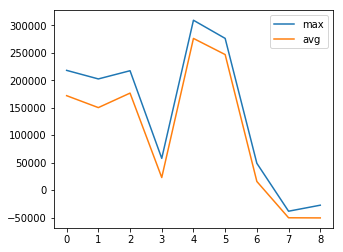

In [65]:
screens, max_r, avg_r = general_optimal_policy([100, 500], transition2, [5, 2], R_)
plot_r(max_r, avg_r)

### Simulate multiple movies

82.87772107124329
65.55954623222351
16.19458293914795
121.52397799491882


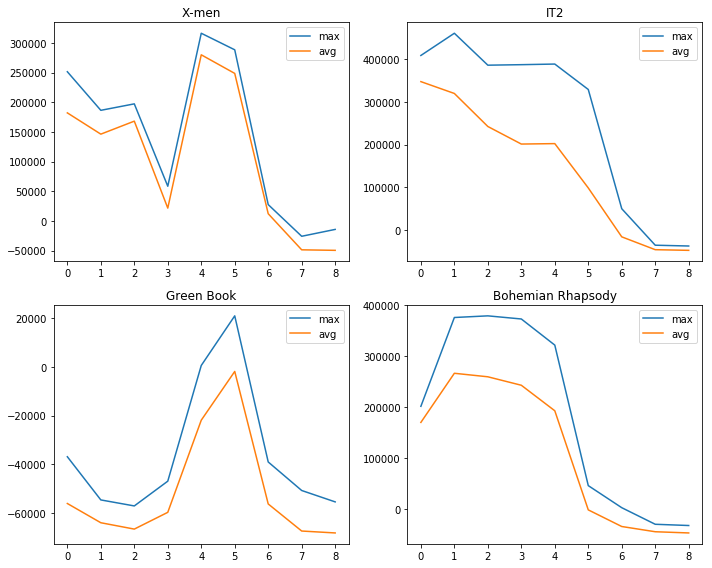

In [84]:
x_men = ('X-men', [100, 500], transition2, [5, 2], R_)
it2 = ('IT2', [100, 300], transition2, [150, 90, 60, 30, 30], R_)
green_book = ('Green Book', [200], transition2, [30, 30, 300], R_)
bohemian_rhapsody = ('Bohemian Rhapsody', [50], transition2, [1], R_)
movies = [x_men, it2, green_book, bohemian_rhapsody]

fig = plt.figure(figsize=(10, 8))
for i, m in enumerate(movies):
    start = time.time()
    screens, max_r, avg_r = general_optimal_policy(m[1], m[2], m[3], m[4])
    print(time.time() - start)
    ax = fig.add_subplot(2, 2, i+1)
    ax.plot([n for n in range(len(max_r))], max_r, label='max')
    ax.plot([n for n in range(len(max_r))], avg_r, label='avg')
    ax.set_title(m[0])
    ax.legend()
    
plt.tight_layout()
plt.show()